# VAR - Vector AutoRegression

Used when variables affect each other <br>
Each variable has an equation explaining its evolution based on:<br>
* its own lagged values
* the lagged values of the other model variables
* and an error term
The only prior knowledge required is a list of variables which can be hypothesized to affect each other intertemporally <br>


#### Process
1. Examine the data
2. Visualize the data
3. Test for stationarity
4. Select the appropriate order p - use auto_arima
5. Instantiate the model and fit it to the training set
6. If necessary, intert the earlier transformation used to get the the data stationary
7. Evaluate model predictions against a known test set
8. Forecast the future

Identify the best value of p for VAR model <br>
Pyramid Auto Arima won't do a grid search. Instead, run various p values through a loop and then check which model has the best AIC <br>
as the p value increase, AIC will decrease, however, at a certain point, the complexity of the AIC model will punish more complex models, and AIC will incrase <br>
Need to check manually for stationarity and difference the time series if they are not stationary<br>
Each time series need to be differenced the same amount of times in order to ensure they have the same number of rows


In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('/content/drive/MyDrive/0.Cloud Computing and Streaming Tech/OCI AI/0.GoogleColab/PythonForTimeSeriesJosePortilla/UDEMY_TSA_FINAL/Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('/content/drive/MyDrive/0.Cloud Computing and Streaming Tech/OCI AI/0.GoogleColab/PythonForTimeSeriesJosePortilla/UDEMY_TSA_FINAL/Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [4]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


#### Combine the 2 dataframes

In [5]:
df = df.join(sp)

In [6]:
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [7]:
df.shape

(252, 2)

In [8]:
df = df.dropna()

In [9]:
df.shape

(252, 2)

<Axes: xlabel='Date'>

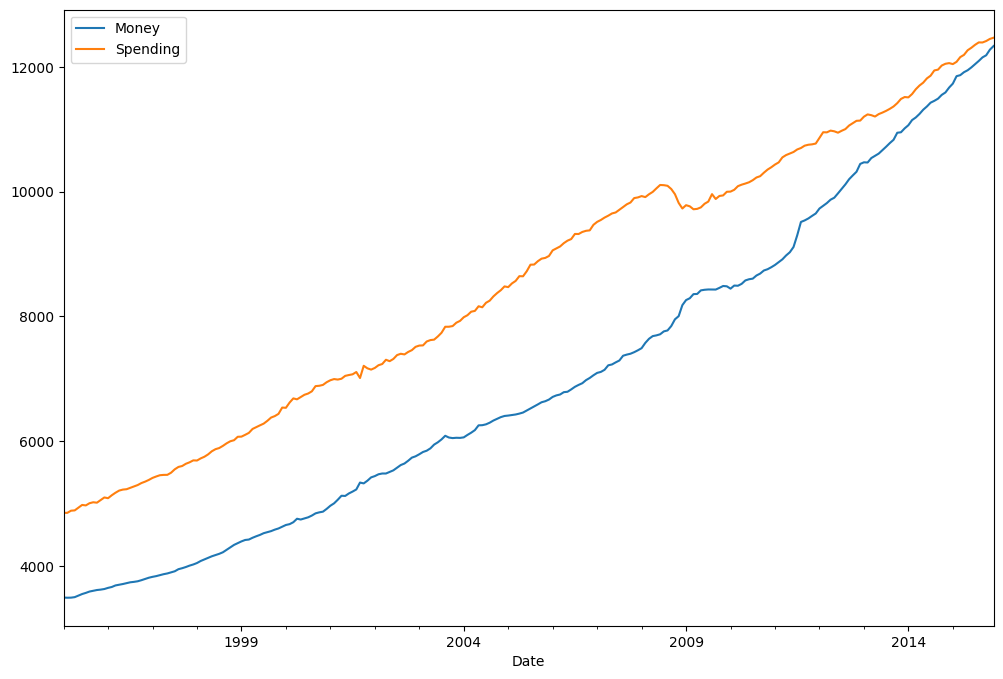

In [10]:
df.plot(figsize=(12,8))

#### Test for stationarity and make any necessary transformations (i.e. differencing the dataset)

ADF function

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### Since both are non-stationary, take a 1st order difference of the entire dataframe

In [14]:
df_transformed = df.diff()

#### Run ADF to check for Stationarity

In [15]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [16]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### Since Money is not stationary, apply a 2nd order differenceing to BOTH dataframes

In [17]:
df_transformed = df_transformed.diff().dropna()

In [18]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#### Check that money is now stationary

In [19]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
df_transformed.shape

(250, 2)

## Train-Test Split

In [22]:
# set number of observations
nobs = 12

In [23]:
train = df_transformed[:-nobs] # start from the begining on DF --> then -12 from the end
test = df_transformed[-nobs:] # start -12 from the end of DF --> and go to the true end of DF

In [24]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


#### Choose the order of the Vector Autoregression (VAR) Model

## GRIDSEARCH for Order p for the AR of VAR model

In [25]:
# for look to work out the lags (p) by fitting the mode to each of the p values (auto_arima does not work in this instance)
# choose the p with the lowest AIC

model = VAR(train)

for p in [1,2,3,4,5,6,7]: # or range(8)
  results = model.fit(p)
  print(f'Lag Order = {p}')
  print(f'AIC : {results.aic}')
  print('\n')

Lag Order = 1
AIC : 14.178610495220896


Lag Order = 2
AIC : 13.955189367163705


Lag Order = 3
AIC : 13.849518291541038


Lag Order = 4
AIC : 13.827950574458281


Lag Order = 5
AIC : 13.787300344609642


Lag Order = 6
AIC : 13.799076756885807


Lag Order = 7
AIC : 13.797638727913972




The lowest AIC<br>
Lag Order = 5<br>
AIC : 13.787300344609642<br>

In [26]:
resutlts = model.fit(5)

In [27]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Dec, 2025
Time:                     01:56:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.2447
Nobs:                     231.000    HQIC:                   13.9780
Log likelihood:          -2219.18    FPE:                    982647.
AIC:                      13.7976    Det(Omega_mle):         866465.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.723987         1.785683            0.405           0.685
L1.Money           -0.691409         0.070336           -9.830           0.000
L1.Spending        -0.134870         0.053049           -2.542      

## Predict the Next 12 Values

In [27]:
# sreps = 12
# p - the lag order (7)
# k = 2 (number of time series terms)
# y: ndarray (p x k) - in this case a 7 x 2 numpy array

In [29]:
# getting the 7 lag values right before the test starts
train.values[-7:].shape

(7, 2)

In [30]:
lagged_values = train.values[-7:]

In [32]:
z = resutlts.forecast(y=lagged_values, steps=12)

In [33]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [36]:
# transform z into a dataframe
idx = pd.date_range('2015-01-01', periods=12, freq='MS')

In [37]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [42]:
df_forecast = pd.DataFrame(data=z, index=idx, columns=['Money_2d', 'Spending_2d'])

In [39]:
# predicted values
df_forecast

,MOney_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [40]:
# actual values
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


#### Invert the Transformation - Reverse the 1st and 2nd difference

In [43]:
# money column - Undoing the 1st and 2nd difference
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [44]:
# spending column - Undoing the 1st and 2nd difference
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [45]:
# differenced and forecasts
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [47]:
# test range to plot
test_range = df[-nobs:]

In [50]:
test_range

,Money,Spending
Date,,
2015-01-01,11733.2,12046.0
2015-02-01,11852.4,12082.4
2015-03-01,11868.8,12158.3
2015-04-01,11916.1,12193.8
2015-05-01,11947.6,12268.1
2015-06-01,11993.1,12308.3
2015-07-01,12045.3,12355.4
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8


<Axes: xlabel='Date'>

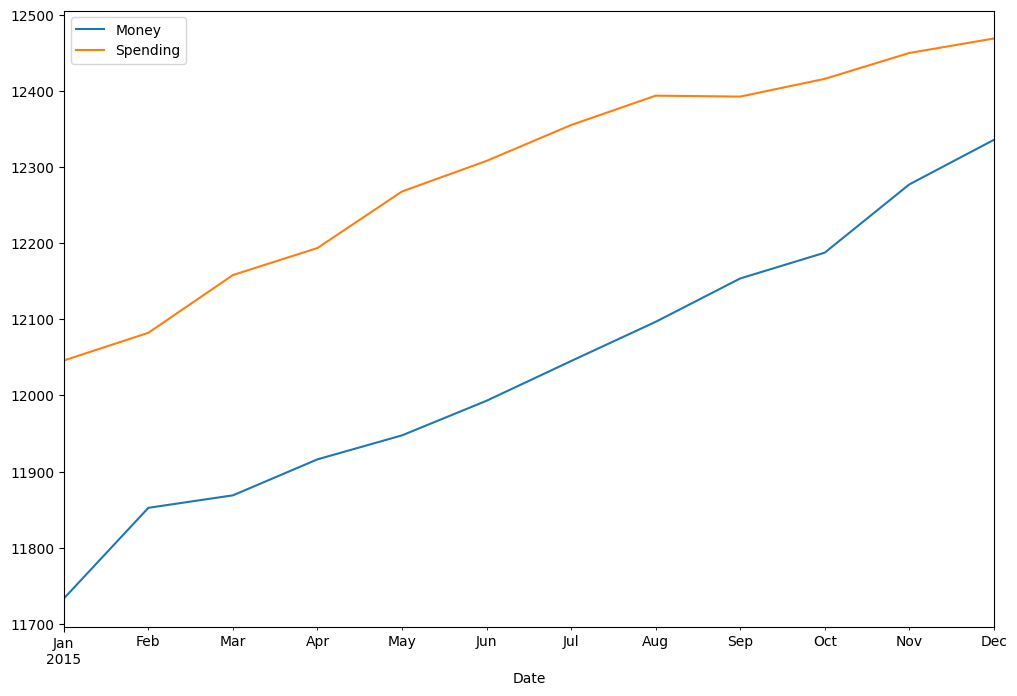

In [51]:
test_range.plot(figsize=(12,8))

In [52]:
df_forecast.columns

Index(['Money_2d', 'Spending_2d', 'Money1d', 'MoneyForecast', 'Spending1d',
       'SpendingForecast'],
      dtype='object')

<Axes: >

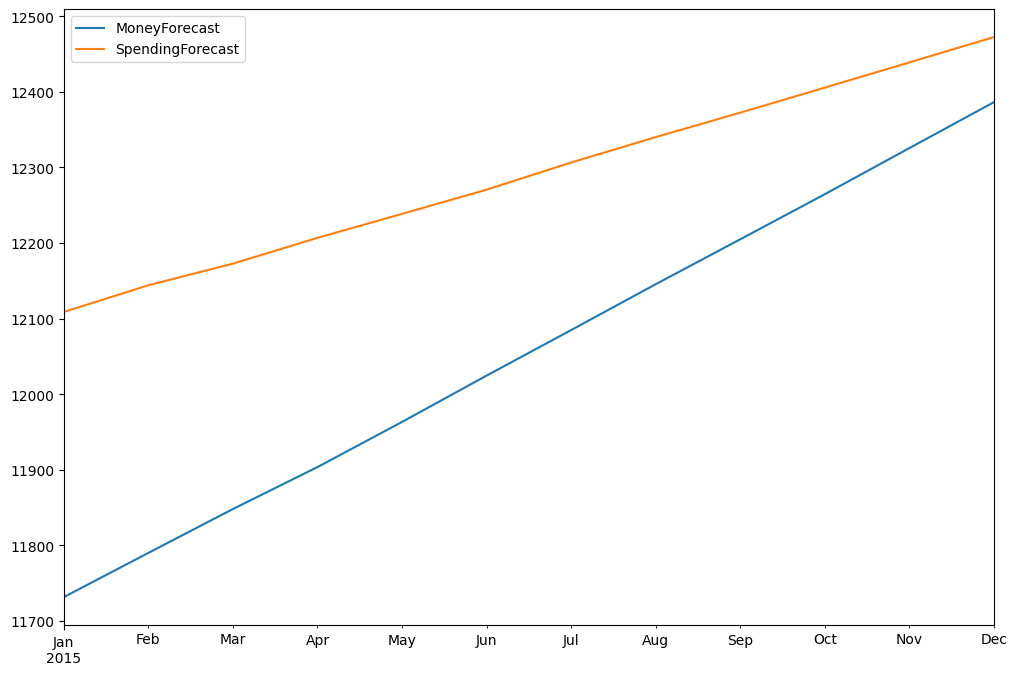

In [53]:
# plot forecasted
df_forecast[['MoneyForecast', 'SpendingForecast']].plot(figsize=(12,8))

<Axes: xlabel='Date'>

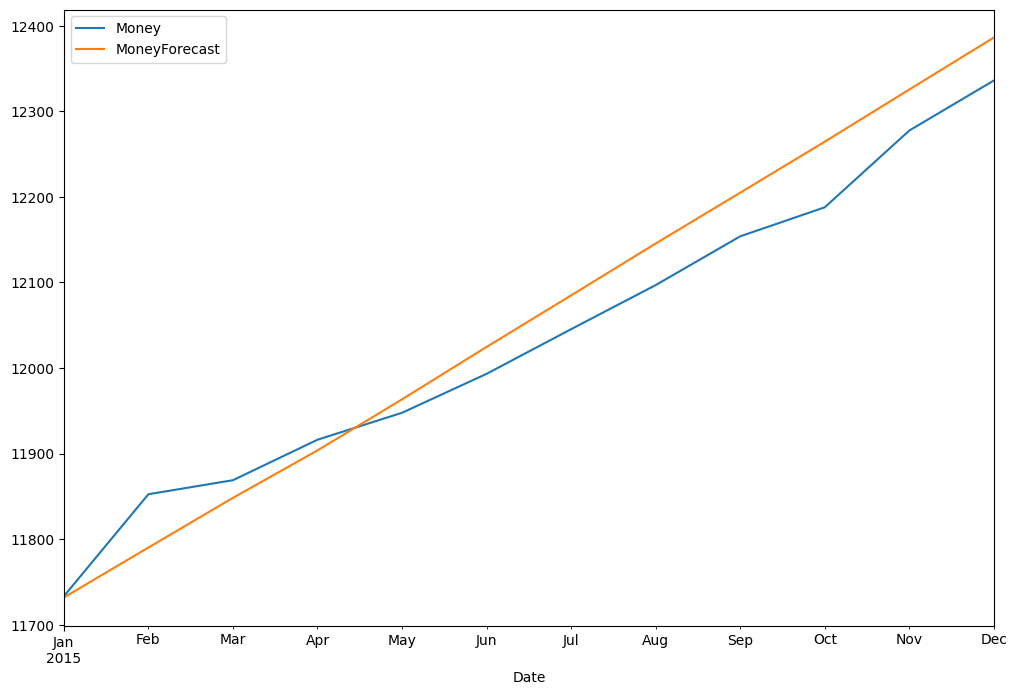

In [55]:
# plot money test and forecast
test_range['Money'].plot(figsize=(12,8), legend = True)
df_forecast['MoneyForecast'].plot(legend=True)

<Axes: xlabel='Date'>

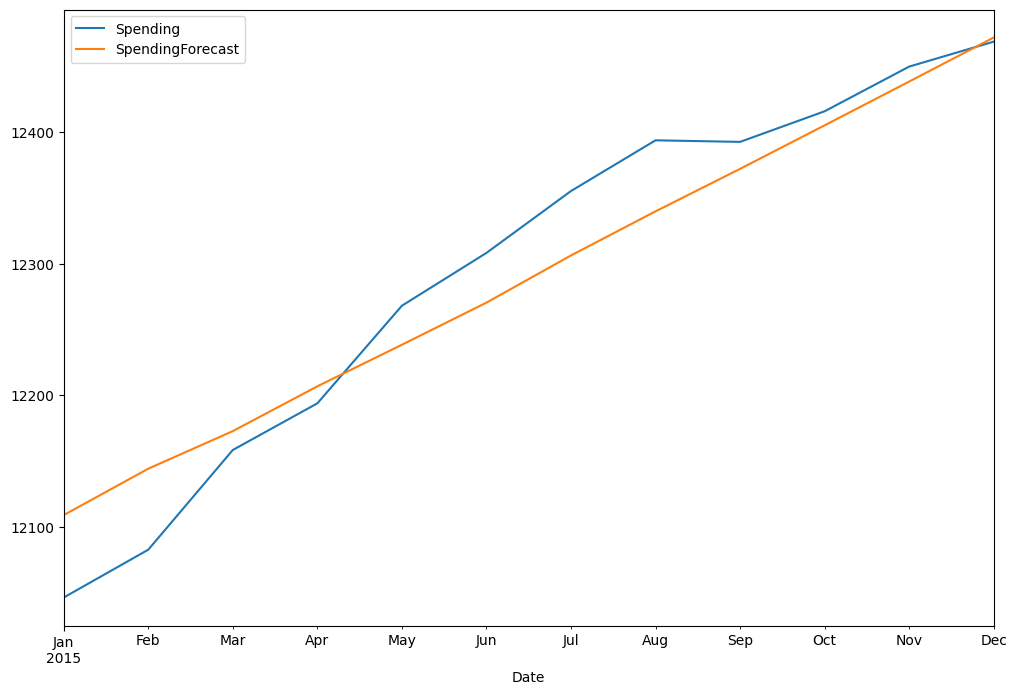

In [56]:
# plot spending test and forecast
test_range['Spending'].plot(figsize=(12,8), legend = True)
df_forecast['SpendingForecast'].plot(legend=True)

#### Evaluate model using RMSE

In [57]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

np.float64(43.71049653558875)

In [59]:
test_range['Money'].mean()

np.float64(12034.008333333333)

In [60]:
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

np.float64(37.00117516940808)

In [62]:
test_range['Spending'].mean()

np.float64(12294.533333333335)